In [76]:
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32


from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *


### 1. Simulating the data

In [77]:
rng = np.random.RandomState(42)
n_rct_before_split = 10**4
n_host = 200
n_mirror = 500
n_cand2 = 500
sigma_prior = 1
sigma_rand_error = 1

power_x, power_x_t = 1, 1
causal_param_first_index = 3
outcome_function = lambda X, T, eps: 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * T + 1* X[:,0]*T + -1* X[:,1]*T + eps 
std_true_y = 0.01 # Standard deviation for the true Y

X0 = np.random.randint(0, 2, size= n_rct_before_split)
X1 = np.random.normal(size=n_rct_before_split)
x_distributions= {0: X0, 1: X1}

p_assigned_to_host = lambda X_1, X_2, T, eps: sigmoid(1 + 2*X_1 - X_2 + T + eps)
p_assigned_to_cand2 = lambda X_1, X_2, T, eps: sigmoid(1 - 2*X_1 + eps)

In [78]:
X_rct, T_rct = generate_rct(n_rct_before_split, x_distributions)
design_data_host, design_data_mirror = generate_host_and_mirror(X_rct, T_rct, p_assigned_to_cand2, n_host, n_mirror, power_x, power_x_t, outcome_function, std_true_y)

pre_X_cand2, pre_T_cand2 = generate_rct(n_rct_before_split, x_distributions)
design_data_cand2 = generate_cand2(pre_X_cand2, pre_T_cand2, p_assigned_to_cand2, n_cand2, \
                                    power_x, power_x_t, outcome_function, std_true_y)

X_mirror, Y_mirror = design_data_mirror.drop(columns=['Y']), design_data_mirror['Y']
X_cand2, Y_cand2 = design_data_cand2.drop(columns=['Y']), design_data_cand2['Y']

### 2. Simulating from prior and plotting
Note: I don't think this is the right way to compare if our estimates are getting better but it will do for now

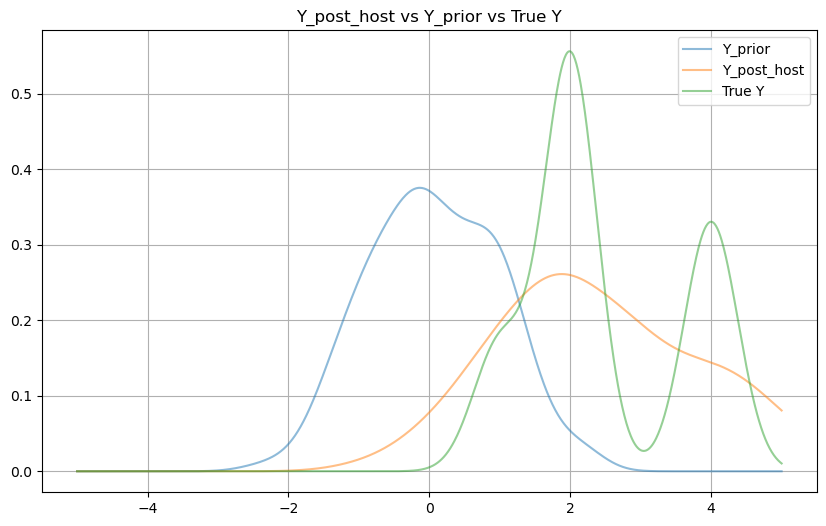

In [79]:
# Initialize prior parameters
post_mean = np.array([0,0 , 0, 0, 0, 0])
beta_0, sigma_0_sq,inv_cov_0 = post_mean, sigma_rand_error**2,1/sigma_prior*np.eye(len(post_mean)) 
prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq,"inv_cov_0":inv_cov_0}
bayes_reg = BayesianLinearRegression(prior_hyperparameters)

### Bayesian update through host dataset
X_host, Y_host= design_data_host.drop(columns=['Y']), design_data_host['Y']
post_host_parameters = bayes_reg.fit(np.array(X_host.values), np.array(Y_host.values))

# Generate Y_prior
Y_prior = np.dot(X_host, beta_0) + np.random.normal(0, sigma_rand_error, len(X_host))

# Generate Y_post_host
beta_post_host_vec = post_host_parameters['posterior_mean'].flatten()  # Extract posterior mean
cov_matrix_post_host = post_host_parameters['posterior_cov_matrix']
Y_post_host = np.dot(X_host, beta_post_host_vec) + np.random.normal(0, 1, len(X_host))  # Assuming standard deviation for Y_post_host is 1

plot_densities(Y_prior, Y_post_host, design_data_host['Y'], 
                names = ['Y_prior', 'Y_post_host', 'True Y'], 
                title = 'Y_post_host vs Y_prior vs True Y')


In [80]:
# ### Bayesian update through candidate datasets
# sigma_cand = 1
# prior_hyperparameters_cand = {'beta_0': beta_post_host_vec, 'sigma_0_sq': sigma_cand}

# ## With candidate = mirror dataset
# bayes_reg_mirror = BayesianLinearRegression(prior_hyperparameters_cand)
# X_mirror, Y_mirror = design_data_mirror.drop(columns=['Y']), design_data_mirror['Y']
# post_mirror_parameters = bayes_reg_mirror.fit(X_mirror, Y_mirror)

# # Generate Y_post_mirror
# post_mirror_mean = post_mirror_parameters['posterior_mean'].flatten()  # Extract posterior mean
# Y_post_mirror = np.dot(X_mirror, post_mirror_mean) + np.random.normal(0, 1, len(X_mirror))  # Assuming standard deviation for Y_post_host is 1

# ## With candidate = cand2 dataset
# bayes_reg_cand2 = BayesianLinearRegression(prior_hyperparameters_cand)
# X_cand2, Y_cand2 = design_data_cand2.drop(columns=['Y']), design_data_cand2['Y']
# post_cand2_parameters = bayes_reg_cand2.fit(X_cand2, Y_cand2)

# # Generate Y_post_cand2
# post_cand2_mean = post_cand2_parameters['posterior_mean'].flatten()  # Extract posterior mean
# Y_post_cand2 = np.dot(X_cand2, post_cand2_mean) + np.random.normal(0, 1, len(X_cand2))  # Assuming standard deviation for Y_post_host is 1

# plot_densities(Y_post_mirror, Y_post_cand2, design_data_host['Y'],
#                 names = ['Y_post_mirror', 'Y_post_cand2', 'True Y'], 
#                 title = 'Y_post_mirror vs Y_post_cand2 vs True Y')


In [81]:
#Number of samples used to estimate outer expectation
n_samples_for_expectation = 100
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))
# Incorporating sqrt constraint into MCMC samples
n_mcmc = (n_samples_for_expectation * (m_samples_for_expectation+1)) 

warmup_steps = 10
max_tree_depth = 7
sigma_rand_error = sigma_0_sq

X_torch = torch.tensor(X_host.values)
Y_torch = torch.tensor(Y_host.values)

## Bayesian update using the host dataset
mcmc_host = MCMC_Bayesian_update(X_torch =X_torch, Y_torch = Y_torch, model =model_normal,
            mu_0= beta_0, sigma_prior = sigma_prior, sigma_rand_error = sigma_rand_error,
            sigma_rand_error_fixed = True,n_mcmc = n_mcmc, warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
mcmc_host.summary()

beta_post_host = pd.DataFrame(mcmc_host.get_samples())

#Shuffling to remove any dependence between adjacent samples
beta_post_host = beta_post_host.sample(frac = 1)

beta_post_host.head()
# We delete the column with the std
beta_post_host_without_std = beta_post_host.iloc[:, :-1] 

Sample: 100%|██████████| 1110/1110 [00:10, 107.85it/s, step size=4.83e-02, acc. prob=0.924]

Inference ran for 0.17 minutes

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0      2.00      0.12      2.00      1.81      2.20    581.73      1.00
    beta_1     -0.99      0.20     -0.98     -1.33     -0.67    378.51      1.00
    beta_2      0.01      0.10      0.01     -0.16      0.16   1069.51      1.00
    beta_3      1.96      0.17      1.96      1.70      2.24    532.08      1.00
    beta_4     -0.95      0.28     -0.95     -1.42     -0.53    401.37      1.00
    beta_5     -0.01      0.13     -0.01     -0.20      0.23    968.25      1.00

Number of divergences: 0


In [82]:
beta_post_host.describe()

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
mean,1.998778,-0.985278,0.006993,1.958853,-0.953982,-0.007054
std,0.119792,0.203816,0.096328,0.165809,0.275717,0.132603
min,1.635677,-1.521158,-0.267657,1.380141,-2.020935,-0.463984
25%,1.918718,-1.127159,-0.055935,1.845030,-1.132353,-0.098949
50%,2.002769,-0.982868,0.008416,1.956052,-0.954558,-0.010616
75%,2.082624,-0.857700,0.069890,2.075950,-0.770400,0.084973
max,2.444138,-0.322546,0.283846,2.471081,-0.164062,0.397720


In [83]:
beta_post_host.cov()

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5
beta_0,0.014350,-0.013330,0.000837,-0.012973,0.012254,-0.001076
beta_1,-0.013330,0.041541,-0.000849,0.010988,-0.038751,0.000483
beta_2,0.000837,-0.000849,0.009279,-0.000671,0.000621,-0.009412
beta_3,-0.012973,0.010988,-0.000671,0.027493,-0.025472,0.001274
beta_4,0.012254,-0.038751,0.000621,-0.025472,0.076020,0.001638
beta_5,-0.001076,0.000483,-0.009412,0.001274,0.001638,0.017583


In [84]:
pd.DataFrame(beta_post_host.cov()- cov_matrix_post_host)

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5
beta_0,-0.000200,0.000395,0.000443,0.001148,-0.000717,-0.000682
beta_1,0.000395,-0.000854,-0.000285,-0.001891,0.001780,-0.000105
beta_2,0.000443,-0.000285,-0.000147,-0.000298,0.000077,-0.000061
beta_3,0.001148,-0.001891,-0.000298,-0.001659,0.001637,0.000260
beta_4,-0.000717,0.001780,0.000077,0.001637,-0.001869,0.001320
beta_5,-0.000682,-0.000105,-0.000061,0.000260,0.001320,0.000323


### 3. Calculating EIG observational

For the mirror dataset

First, we calculate EIG using samples by getting the model predictions and putting them in the correct form

In [85]:
X_mirror_arr = X_mirror.values
Y_pred_mirror = predict_with_all_sampled_linear(beta_post_host, X_mirror_arr)

pred_list_mirror = predictions_in_EIG_obs_form(Y_pred_mirror,n_samples_for_expectation,m_samples_for_expectation)

In [86]:
compute_EIG_obs_from_samples(pred_list_mirror, sigma_rand_error)

5.040238466434289

Now to calculate for the causal

In [87]:
sample_func = return_causal_samp_func_linear(X=X_torch,Y=Y_torch,causal_param_first_index=3,mu_0=beta_0,sigma_prior = sigma_prior,
                                            sigma_rand_error = sigma_rand_error,sigma_rand_error_fixed = True,warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
pred_func = lambda beta: beta @ (X_mirror).T

In [88]:
# pred_in_causal_form = predictions_in_EIG_causal_form(pred_func, theta_samples=beta_post_host.values[:40], theta_sampling_function=sample_func, n_non_causal_expectation=100, causal_param_first_index=3)

In [89]:
# compute_EIG_causal_from_samples(pred_list_mirror,pred_in_causal_form, sigma_rand_error)

Now, trying to calculate in closed form

In [90]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host,sigma_rand_error)

3.6701673232749767

In [91]:
compute_EIG_causal_closed_form(X_mirror_arr, cov_matrix_post_host,sigma_rand_error, 3)

1.1241520506590161

For the cand2 dataset

In [92]:
X_cand2_arr = X_cand2.values
Y_pred_cand2 = predict_with_all_sampled_linear(beta_post_host, X_cand2_arr)

pred_list_cand2 = predictions_in_EIG_obs_form(Y_pred_cand2, n_samples_for_expectation, m_samples_for_expectation)

In [93]:
compute_EIG_obs_from_samples(pred_list_cand2, sigma_rand_error)

8.312370168919188

Now, trying to calculate in closed form

In [94]:
compute_EIG_obs_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error)

3.6900844875155885

In [95]:
compute_EIG_causal_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error, 3)

1.0969206417854989

### Sanity Experiments

In [96]:
from scipy.stats import multivariate_normal

In [97]:
mvn = multivariate_normal(mean=beta_post_host_vec, cov=cov_matrix_post_host)

In [98]:
n_samples_for_expectation = 2000
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))

In [99]:
beta = mvn.rvs(n_samples_for_expectation*(m_samples_for_expectation+1))

In [100]:
beta.shape

(92000, 6)

In [101]:
sigma_rand_error = 1

In [102]:
y_pred_vec = predict_with_all_sampled_linear(pd.DataFrame(beta), X_mirror_arr)

In [103]:
y_pred_form = predictions_in_EIG_obs_form(y_pred_vec, n_samples_for_expectation, m_samples_for_expectation)

In [104]:
compute_EIG_obs_from_samples(y_pred_form, sigma_rand_error)

5.049881177021348

In [105]:
calc_posterior_predictive_entropy(y_pred_form, sigma_rand_error)

Sample:  21%|██        | 232/1110 [00:21, 110.29it/s, step size=4.74e-02, acc. prob=0.942]

713.9648671493129

In [106]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host,sigma_rand_error)

3.6701673232749767

In [107]:
n_e = len(y_pred_form[0][0])
X = X_mirror_arr
sign,log_det_term = np.linalg.slogdet( X @ ((cov_matrix_post_host) @ X.T) + (sigma_rand_error**2) * np.eye(n_e) )
1/2*log_det_term + n_e/2 * (1 + np.log(2 * np.pi))

713.1394339256113

In [108]:
beta_repeat = np.tile(beta_post_host_vec,(len(beta),1))

In [109]:
y_pred_vec_repeat = predict_with_all_sampled_linear(pd.DataFrame(beta_repeat), X_mirror_arr)

In [110]:
y_pred_vec.shape

(92000, 500)

In [111]:
y_pred_vec_repeat.shape

(92000, 500)

In [112]:
y_pred_form_repeat = predictions_in_EIG_obs_form(y_pred_vec_repeat, n_samples_for_expectation, m_samples_for_expectation)

In [113]:
cov_matrix_post_host_zero = np.zeros_like(cov_matrix_post_host)

In [114]:
sigma_repeat = 0.0001

In [115]:
compute_EIG_obs_from_samples(y_pred_form_repeat,  sigma_repeat)

-0.2012644936221477

In [116]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host_zero,sigma_repeat)

-9.094947017729282e-12

In [117]:
n_e = len(y_pred_form_repeat[0][0])
X = X_mirror_arr
sign,log_det_term = np.linalg.slogdet( X @ ((cov_matrix_post_host_zero) @ X.T) + (sigma_repeat**2) * np.eye(n_e) )
1/2*log_det_term + n_e/2 * (1 + np.log(2 * np.pi))

-3895.700919385764

In [118]:
calc_posterior_predictive_entropy(y_pred_form_repeat, sigma_repeat)

-3895.6722024874466

In [119]:
cov_matrix_post_host_id = np.eye(6)
mvn_id = multivariate_normal(mean=beta_post_host_vec, cov=cov_matrix_post_host_id)
n_samples_for_expectation = 500
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))
beta_id = mvn_id.rvs(n_samples_for_expectation*(m_samples_for_expectation+1))

In [120]:
sigma_rand_error = 1

In [121]:
y_pred_vec_id = predict_with_all_sampled_linear(pd.DataFrame(beta_id), X_mirror_arr)
y_pred_form_id = predictions_in_EIG_obs_form(y_pred_vec_id, n_samples_for_expectation, m_samples_for_expectation)

In [122]:
compute_EIG_obs_from_samples(y_pred_form_id, sigma_rand_error)

360.17254162456425

In [123]:
sign, log_det_term = np.linalg.slogdet(X_mirror_arr.T @ X_mirror_arr + cov_matrix_post_host)
log_det_term

30.066570743698733

In [124]:
sign, log_det_term =np.linalg.slogdet(X_mirror_arr @ (cov_matrix_post_host @ X_mirror_arr.T) + np.eye(len(X_mirror_arr)))
log_det_term

7.3403346465499535

In [125]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host_id,sigma_rand_error)

15.080597854446653

Below calculates from samples

In [126]:
calc_posterior_predictive_entropy(y_pred_form_id, sigma_rand_error)

1070.4829435254615

Closed form of same term

In [127]:
n_e = len(y_pred_form_repeat[0][0])
X = X_mirror_arr
sign,log_det_term = np.linalg.slogdet( X @ ((cov_matrix_post_host_id) @ X.T) + (sigma_rand_error**2) * np.eye(n_e) )
1/2*log_det_term + n_e/2 * (1 + np.log(2 * np.pi))

724.549864456783

In [128]:
n_e/2 * (1 + np.log(2 * np.pi))

709.4692666023363

In [129]:
sign, log_det = np.linalg.slogdet(X @ ((100000*cov_matrix_post_host_id) @ X.T))
log_det

-10185.749338094736

In [130]:
np.linalg.det(X @ ((cov_matrix_post_host_id) @ X.T))

-0.0

In [131]:
pred_list = y_pred_form_id
sigma = sigma_rand_error
n_e = len(pred_list[0][0])
covariance = cov.CovViaDiagonal(sigma**2*np.ones(n_e))
sample_list = []

for y_pred,y_pred_multiple in pred_list:
    mvn = multivariate_normal(mean=y_pred, cov=covariance)
    y_sample = mvn.rvs()
    sample_list.append(log_posterior_predictive(y_sample,y_pred_multiple,covariance))

In [ ]:
pred_list = y_pred_form_id
sigma = sigma_rand_error
n_e = len(pred_list[0][0])
covariance = cov.CovViaDiagonal(sigma**2*np.ones(n_e))
sample_list = []

for y_pred,y_pred_multiple in pred_list:
    mvn = multivariate_normal(mean=y_pred, cov=covariance)
    y_sample = mvn.rvs()
    sample_list.append(log_posterior_predictive(y_sample,y_pred_multiple,covariance))

In [150]:
mvn = multivariate_normal(mean=y_pred_vec_id[0], cov=covariance)
y_sample = mvn.rvs()

In [151]:
y = y_sample
y_pred_theta_samples = y_pred_vec_id[1:]
n_e = len(y)

log_likelihood_list = []
for y_pred in y_pred_theta_samples:
    log_likelihood_list.append(multivariate_normal_log_likelihood(y, y_pred, covariance))
lsum = logsumexp(log_likelihood_list) 

In [152]:
max(log_likelihood_list)

-739.3374130390305

In [144]:
lsum+ np.log(len(log_likelihood_list))

-1093.7017073821157

In [135]:
prior_matrix = np.eye(6)

In [136]:
sign, log_det_term_post = np.linalg.slogdet((1/sigma**2)*X_host.T @ X_host + np.linalg.inv(prior_matrix))
sign, log_det_term_prior = np.linalg.slogdet(np.linalg.inv(prior_matrix))
1/2*log_det_term_post - 1/2* log_det_term_prior

26.286291705017188